# We smooth spectra with a variety of techniques, and then baseline correct and normalise them for comparison with the ground truth

In [1]:

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from BaselineRemoval import BaselineRemoval



In [2]:
# all of these files are generated at the end of a training epoch. 
# The are the test set of spectra, the corresponding ground truths, and the network denoised data

network_pred=np.load('network_denoised.npy')
network_pred_GT = np.load('network_denoised_GT.npy')
network_pred_input = np.load('network_input.npy')
# we duplicate the noisy spectra so we can baseline correct/normalise them for plotting, 
# while using the originals for our denoising techniques
network_pred_input_baseline_norm = network_pred_input

In [3]:
# test spectra used for evaluation
test_example = np.squeeze(network_pred_input)




In [4]:
#baseline correct and normalise these spectra based on max value

for i in range(np.shape(network_pred)[0]):
    baseObj=BaselineRemoval(network_pred_GT[i])
    Modpoly_output=baseObj.ModPoly(3)
    network_pred_GT[i] = Modpoly_output/np.max(Modpoly_output)
    
    baseObj=BaselineRemoval(network_pred[i])
    Modpoly_output=baseObj.ModPoly(3)
    #network_pred[i] = Modpoly_output/Modpoly_output[np.where(network_pred_GT[i] == np.max(network_pred_GT[i]))[0][0]]
    network_pred[i] = Modpoly_output/np.max(Modpoly_output)
    
    baseObj=BaselineRemoval(network_pred_input[i])
    Modpoly_output=baseObj.ModPoly(3)
    #network_pred[i] = Modpoly_output/Modpoly_output[np.where(network_pred_GT[i] == np.max(network_pred_GT[i]))[0][0]]
    network_pred_input_baseline_norm[i] = Modpoly_output/np.max(Modpoly_output)
    
    
    



# MSE for network denoised spectra

In [5]:
network_MSE = np.mean(np.mean((np.squeeze(network_pred) - np.squeeze(network_pred_GT))**2,axis=1))
print(network_MSE)

0.022144250704377484


### plot example

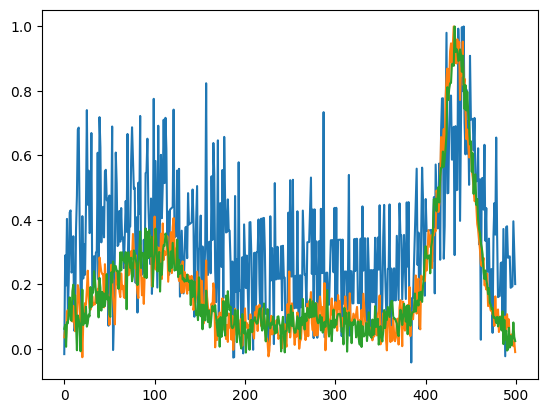

In [6]:
index = 50
plt.plot(network_pred_input_baseline_norm[index])
plt.plot(network_pred[index])
plt.plot(network_pred_GT[index])

# savitsky golay smooothing

In [7]:
y_smooth = np.zeros(np.shape(test_example))
for i in range(np.shape(test_example)[0]):
    y_smooth[i] = signal.savgol_filter(test_example[i], window_length=50, polyorder=3, mode="nearest")

# baseline correct/normalise
for i in range(np.shape(y_smooth)[0]):
    baseObj=BaselineRemoval(y_smooth[i])
    mod=baseObj.ModPoly(3)
    y_smooth[i]=mod/np.max(mod)

In [8]:
## SG MSE

In [9]:
SG_MSE = np.mean(np.mean((np.squeeze(y_smooth) - np.squeeze(network_pred_GT))**2,axis=1))
print(SG_MSE)

0.03591827320750099


### plot

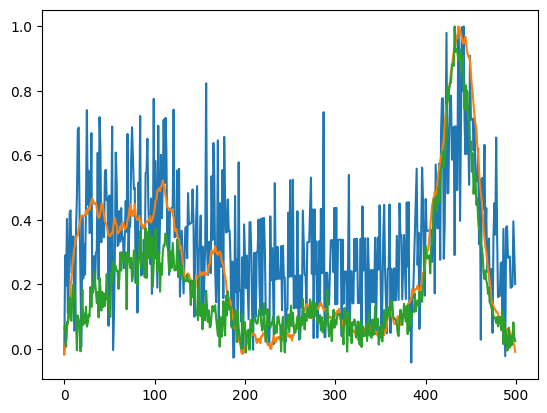

In [10]:


plt.plot(network_pred_input_baseline_norm[index])
plt.plot(y_smooth[index])
plt.plot(network_pred_GT[index])



# PCA denoising

In [11]:
#PCA denoising - https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html

from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=2)


pca.fit(np.squeeze(test_example))


# kernel pca
#kernel_pca = KernelPCA(
#    n_components=15, kernel="rbf", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3
#)
#_ = kernel_pca.fit(np.squeeze(noisy_tr))

#X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
#    kernel_pca.transform(test_example)
#)


PCA(n_components=2)

In [12]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(test_example))

In [13]:
# baseline correct/normalise

In [14]:

for i in range(np.shape(X_reconstructed_pca)[0]):
    baseObj=BaselineRemoval(X_reconstructed_pca[i])
    mod=baseObj.ModPoly(3)
    X_reconstructed_pca[i]=mod/np.max(mod)


### PCA MSE

In [15]:
PCA_MSE = np.mean(np.mean((np.squeeze(X_reconstructed_pca) - np.squeeze(network_pred_GT))**2,axis=1))
print(PCA_MSE)

0.048980115903721415


### plot

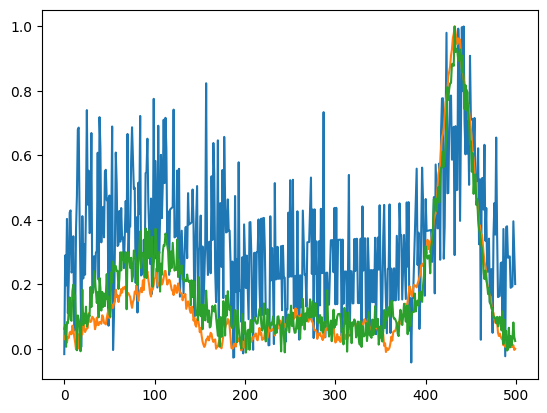

In [16]:
index=50
plt.plot(network_pred_input_baseline_norm[index])
plt.plot(np.squeeze(X_reconstructed_pca[index]))
plt.plot(network_pred_GT[index])


# Wavelet denoising

In [17]:
import numpy as np
#import PyWavelets as pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt

spec_denoise_w = np.zeros(np.shape(test_example))
for i in range(np.shape(test_example)[0]):
    spec_denoise_w[i] = denoise_wavelet(test_example[i], method='BayesShrink', mode='soft', wavelet_levels=10, wavelet='sym8', rescale_sigma='True')

In [18]:
#baseline correct and normalise

for i in range(np.shape(spec_denoise_w)[0]):
    baseObj=BaselineRemoval(spec_denoise_w[i])
    mod=baseObj.ModPoly(3)
    spec_denoise_w[i]=mod/np.max(mod)




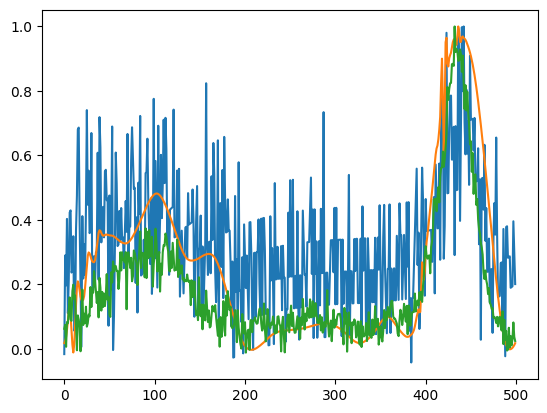

In [20]:
##plot 
plt.plot(network_pred_input_baseline_norm[index])
plt.plot(np.squeeze(spec_denoise_w[index]))
plt.plot(network_pred_GT[index])


In [21]:
## MSE wavelet

In [22]:
wav_MSE = np.mean(np.mean((np.squeeze(spec_denoise_w) - np.squeeze(network_pred_GT))**2,axis=1))
print(wav_MSE)

0.03224999479950793


# NOVA metric - https://www.pythonfordatascience.org/anova-python/#test_with_python

import scipy.stats as stats

stats.f_oneway(np.squeeze(x_denoise), test_example)